In [ ]:
!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
!unzip Covid_Data_GradientCrescent.zip
!rm Covid_Data_GradientCrescent.zip
!rm -rf /content/all/test/pneumonia_vir
!rm -rf /content/all/train/pneumonia_vir

Downloading...
From: https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
To: /content/Covid_Data_GradientCrescent.zip
154MB [00:01, 119MB/s] 
Archive:  Covid_Data_GradientCrescent.zip
   creating: all/
   creating: all/test/
   creating: all/test/covid/
  inflating: all/test/covid/nejmoa2001191_f3-PA.jpeg  
  inflating: all/test/covid/nejmoa2001191_f4.jpeg  
  inflating: all/test/covid/nejmoa2001191_f5-PA.jpeg  
  inflating: all/test/covid/radiol.2020200490.fig3.jpeg  
  inflating: all/test/covid/ryct.2020200028.fig1a.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig2.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day0.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day4.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day7.jpeg  
   creating: all/test/normal/
  inflating: all/test/normal/NORMAL2-IM-1385-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1396-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1400-0001.jpeg  
  inflating: all

In [ ]:
import numpy as np
import tensorflow as tf
import shutil
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [ ]:
DATASET_PATH = '/content/all/train'
test_dir = '/content/all/test'
IMAGE_SIZE = (150, 150)
NUM_CLASSES = 3
BATCH_SIZE = 10 # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS = 20
LEARNING_RATE =0.0001 
FOLDS = 10

In [ ]:
class DirectoryStratifiedKFold:
  
  def __init__(self, directory, k, fold_dir = '/content'):
    self.directory = directory
    self.k = k
    self.fold_dir = fold_dir
    self.labels = os.listdir(directory) 
    self.files = []

    for label in self.labels:
      self.files.append(os.listdir(directory + '/' + label))

  def gen_fold(self, n, base = '__tempfold__'):
    fold = self.fold_dir + '/' + base + str(n)
    sub_train = '/train'
    sub_test = '/test'
    if not os.path.isdir(fold):
      os.mkdir(fold)
      os.mkdir(fold + sub_train)
      os.mkdir(fold + sub_test)
      for label, files in zip(self.labels, self.files):
        os.mkdir(fold + sub_train + '/' + label)
        os.mkdir(fold + sub_test + '/' + label)
        lower = (n) * (len(files) / self.k)
        upper = (n + 1) * (len(files) / self.k)
        for i, file in enumerate(files):
          if (lower <= i and i < upper):
            shutil.copy(self.directory + '/' + label + '/' + file, fold + sub_test + '/' + label + '/' + file)
          else:
            shutil.copy(self.directory + '/' + label + '/' + file, fold + sub_train + '/' + label + '/' + file)

    return (fold + sub_train, fold + sub_test)

  def del_fold(self, n, base = '__tempfold__'):
    fold = self.fold_dir + '/' + base + str(n)
    if os.path.isdir(fold):
      shutil.rmtree(fold)

  def shuffle(self):
    for label in self.files:
      np.random.shuffle(label)


In [ ]:
#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   fill_mode='constant')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
#Train datagen here is a preprocessor
#old
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')
train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = 'training',
                                                  seed=42,
                                                  class_mode='categorical')
valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = 'validation',
                                                  seed=42,
                                                  class_mode='categorical')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 160 images belonging to 3 classes.
Found 40 images belonging to 3 classes.


In [ ]:
from keras import models
from keras import layers
from keras.applications import VGG16
from keras import optimizers
from keras.layers.core import Flatten, Dense, Dropout, Lambda
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])
weights = model.get_weights()

58892288/58889256 [==============================] - 5s 0us/step


In [ ]:
test_batches = train_datagen.flow_from_directory(test_dir,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')

Found 27 images belonging to 3 classes.


In [ ]:
def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over '+ str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
kfold = DirectoryStratifiedKFold(DATASET_PATH, FOLDS)
kfold.shuffle()
results = []
evaluations = []

In [ ]:
for k in range(FOLDS):
  model.set_weights(weights)
  train, test = kfold.gen_fold(k)

  print('\n', 'Fold', k, '\n')

  train_batches = train_datagen.flow_from_directory(train,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')
  valid_batches = train_datagen.flow_from_directory(test,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')

  STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
  STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size
  model.set_weights(weights)
  result = model.fit_generator(train_batches,
                            steps_per_epoch =STEP_SIZE_TRAIN,
                            validation_data = valid_batches,
                            validation_steps = STEP_SIZE_VALID,
                            epochs= NUM_EPOCHS)
  evaluation = model.evaluate_generator(test_batches)

  results.append(result)
  evaluations.append(evaluation)

  plot_acc_loss(result, 20)
  print(evaluation)

  kfold.del_fold(k)


 Fold 0 

Found 180 images belonging to 3 classes.
Found 20 images belonging to 3 classes.
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


18/18 [==============================] - 46s 3s/step - loss: 1.0904 - acc: 0.4389 - val_loss: 1.0831 - val_acc: 0.5000
Epoch 2/20
18/18 [==============================] - 43s 2s/step - loss: 0.9106 - acc: 0.5778 - val_loss: 0.8728 - val_acc: 0.5000
Epoch 3/20
18/18 [==============================] - 44s 2s/step - loss: 0.7837 - acc: 0.6556 - val_loss: 0.8321 - val_acc: 0.6500
Epoch 4/20
18/18 [==============================] - 44s 2s/step - loss: 0.6880 - acc: 0.7444 - val_loss: 0.6895 - val_acc: 0.7500
Epoch 5/20
17/18 [===========================>..] - ETA: 2s - loss: 0.6267 - acc: 0.7412

KeyboardInterrupt: ignored

In [ ]:
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size
result=model.fit_generator(train_batches,
                           steps_per_epoch =STEP_SIZE_TRAIN,
                           validation_data = valid_batches,
                           validation_steps = STEP_SIZE_VALID,
                           epochs= NUM_EPOCHS)

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/16 [==============================] - 51s 3s/step - loss: 1.2019 - acc: 0.3375 - val_loss: 1.2629 - val_acc: 0.2750
Epoch 2/20
16/16 [==============================] - 47s 3s/step - loss: 0.9441 - acc: 0.5562 - val_loss: 1.1698 - val_acc: 0.4250
Epoch 3/20
16/16 [==============================] - 47s 3s/step - loss: 0.8134 - acc: 0.6875 - val_loss: 0.7701 - val_acc: 0.7750
Epoch 4/20
16/16 [==============================] - 47s 3s/step - loss: 0.7305 - acc: 0.7000 - val_loss: 0.8067 - val_acc: 0.7250
Epoch 5/20
16/16 [==============================] - 48s 3s/step - loss: 0.6949 - acc: 0.7312 - val_loss: 0.4977 - val_acc: 0.6500
Epoch 6/20
16/16 [==============================] - 47s 3s/step - loss: 0.6591 - acc: 0.7125 - val_loss: 0.6447 - val_acc: 0.7500
Epoch 7/20
16/16 [==============================] - 48s 3s/step - loss: 0.5566 - acc: 0.8062 - val_loss: 0.6831 - val_acc: 0.7000
Epoch 8/20
16/16 [==============================] - 47s 3s/step - loss: 0.5804 - acc: 0.7250 - val_lo

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over '+ str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()

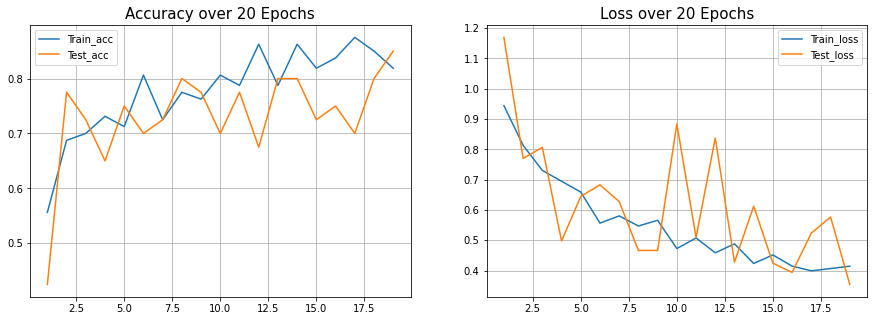

In [ ]:
plot_acc_loss(result, 20)